In [ ]:
import os
import shutil
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
from torchsummary import summary
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time


In [ ]:
def lstm_data_transform(x_data, y_data, num_steps=30):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the mean of the sequence labels and rounding the value for label of the sequency
        mean_arr_y= y_data[i:end_ix]
        y_mean_label=round(np.average(mean_arr_y))
        seq_y = y_mean_label
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    x=torch.from_numpy(x_array)
    y=torch.from_numpy(y_array)
    return x, y

In [ ]:
class PainDataset(Dataset):
    """ Pain dataset."""

    # Initialize your data, download, etc.
    def __init__(self):
        with open('/content/drive/My Drive/LSTM Pain No Pain (Collab)/Data/Pain_features_and_labels_071309_w_21_pain.csv', 'r') as f:
          xy_pain = np.loadtxt(f, delimiter=",",dtype=np.float32,skiprows=1)
        with open('/content/drive/My Drive/LSTM Pain No Pain (Collab)/Data/Pain_features_and_labels_071309_w_21_no_pain.csv', 'r') as f:
          xy_nopain = np.loadtxt(f, delimiter=",",dtype=np.float32,skiprows=1)
        
        x_p=(xy_pain[:,:-1])/5
        y_p=(xy_pain[:,[-1]])
        
        # ## Bringing the length of no pain ot be of the same length as pain data
        # x_np=(xy_nopain[:len(x_p),:-1])
        # y_np=(xy_nopain[:len(x_p),[-1]])

        ## Full length no pain data
        x_np=(xy_nopain[:,:-1])/5
        y_np=(xy_nopain[:,[-1]])
        
        x_combined= np.vstack((x_p,x_np))
        y_combined= np.vstack((y_p,y_np))
        
        x_sequences,y_sequences=lstm_data_transform(x_combined,y_combined)
        
        self.x_data = x_sequences
        self.y_data = y_sequences
        
        self.len = x_sequences.shape[0]
        

    def __getitem__(self, index):
        return self.x_data[index], torch.tensor(self.y_data[index])

    def __len__(self):
        return self.len

In [ ]:
start = time.time()

device = torch.device('cuda')

# Hyper-parameters 
# input_size = 18 AU (Both presence(1) and intensities(17) )
num_classes = 2 ## (Binary classification as pain(0) or no pain(1) )
num_epochs = 150
batch_size = 30
learning_rate = 0.001

input_size = 18
sequence_length = 30
hidden_size = 100
num_layers = 4


## PAIN DATASET

## Add dataset here

dataset = PainDataset()
train_loader = DataLoader(dataset=dataset,batch_size=30,shuffle=True)

# Fully connected neural network with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # -> x needs to be: (batch_size, seq, input_size)
        
        # or:
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Can add sigmoid here itself ################################################## 
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        h0 = torch.ones(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.ones(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # Check list sizes here to match required lengths
        # x: (n, 28, 28), h0: (2, n, 128)
        
        # Forward propagate RNN
        out, _ = self.lstm(x, (h0,c0))  
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # out: (n, 28, 128)
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
        # out: (n, 128)
#         F.log_softmax(self.linear(bow_vec), dim=1)
        out = self.fc(out)
        out= F.log_softmax((out),dim=1)
        # out: (n, 2)
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer setting
# criterion = nn.CrossEntropyLoss() ## Useful for later stage where we might have to use pain levels
criterion = nn.NLLLoss()
# criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
m = nn.Sigmoid()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
## Hinge loss try

In [ ]:
zz=next(iter(train_loader))
zz[0].shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([30, 30, 18])

In [ ]:
# summary(model,input_size=(10,30,18))
print(model)

RNN(
  (lstm): LSTM(18, 100, num_layers=4, batch_first=True)
  (fc): Linear(in_features=100, out_features=2, bias=True)
)


In [ ]:
n_total_steps = len(train_loader)
i=0

loss_count=[]
for epoch in range(num_epochs):
    loss_value=0.0
    for i,data in enumerate(train_loader, 0):
#         print(data)
        features, labels = data
#         print('labels',labels)
#         print('features',features)
        
        features = features.reshape(-1, sequence_length, input_size).to(device)
#         print(features.shape)
        labels = labels.to(device)
        # Forward pass
        outputs = model(features)
#         print(len(labels),len(m(outputs)[0]))
#         print("sh",features.shape)
#         print('out',outputs.shape)
#         print('lab',labels.shape)
        loss = criterion(outputs, labels.long())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i+=1
        loss_value+=loss.item()
        if (i+1) % 1000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.6f}')
    loss_count.append(loss_value/n_total_steps)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/150], Step [1000/1226], Loss: 0.412893
Epoch [2/150], Step [1000/1226], Loss: 0.406653
Epoch [3/150], Step [1000/1226], Loss: 0.554034
Epoch [4/150], Step [1000/1226], Loss: 0.632429
Epoch [5/150], Step [1000/1226], Loss: 0.458982
Epoch [6/150], Step [1000/1226], Loss: 0.589427
Epoch [7/150], Step [1000/1226], Loss: 0.615883
Epoch [8/150], Step [1000/1226], Loss: 0.500196
Epoch [9/150], Step [1000/1226], Loss: 0.618919
Epoch [10/150], Step [1000/1226], Loss: 0.627326
Epoch [11/150], Step [1000/1226], Loss: 0.571573
Epoch [12/150], Step [1000/1226], Loss: 0.483479
Epoch [13/150], Step [1000/1226], Loss: 0.528415
Epoch [14/150], Step [1000/1226], Loss: 0.352832
Epoch [15/150], Step [1000/1226], Loss: 0.453107
Epoch [16/150], Step [1000/1226], Loss: 0.882632
Epoch [17/150], Step [1000/1226], Loss: 0.218636
Epoch [18/150], Step [1000/1226], Loss: 0.400204
Epoch [19/150], Step [1000/1226], Loss: 0.268591
Epoch [20/150], Step [1000/1226], Loss: 0.457963
Epoch [21/150], Step [1000/12

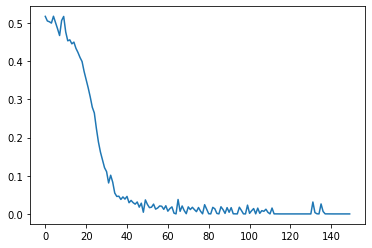

In [ ]:
plt.plot(loss_count)

In [ ]:
## Testing the model for both labels

model.eval()

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for i,data in enumerate(train_loader, 0):
        # print(data)
        features, labels = data
        features = features.reshape(-1, sequence_length, input_size).to(device)
        labels=labels.to(device)
        
        outputs = model(features)
        # print(outputs)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels.long()).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on test data: {acc} %')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Accuracy of the network on test data: 100.0 %


In [ ]:
PATH =r'/content/drive/My Drive/LSTM Pain No Pain (Collab)/Saved_Models/pain_model_100epochs.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
end = time.time()
print('Time taken: ',end - start)

In [ ]:
# import pandas as pd

In [ ]:
# # initialize list of lists 
# data = [['tom', 10], ['nick', 15], ['juli', 14]] 
  
# # Create the pandas DataFrame 
# df = pd.DataFrame(data, columns = ['Name', 'Age']) 
  
# # print dataframe. 
# df 

,Name,Age
0,tom,10
1,nick,15
2,juli,14


In [ ]:
# a='_test_'
# b='_save_'
# df.to_csv(r'/content/drive/My Drive/LSTM Pain No Pain (Collab)/Output/sample'+a+b+'.csv', index = False)